# Examples

This notebook provides some examples of how to use Time Blender.

In [1]:
from time_blender.random_events import *
from time_blender.deterministic_events import *
from time_blender.coordination_events import *

from time_blender.core import *
from time_blender.models import SimpleModels, ClassicModels, BankingModels, EconomicModels, EcologyModels

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd


/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]

Time period to consider.

In [3]:
start_date = pd.Timestamp.now() # or a fixed date, such as pd.Timestamp(2018, 1, 1)
end_date = start_date + pd.DateOffset(months=24)

print(f"Start date = {start_date}, end date = {end_date}")

Start date = 2020-10-30 15:24:20.378613, end date = 2022-10-30 15:24:20.378613


## Predefined Models

The easiest way to use TimeBlender is through the predefined models that ship with it. These are, in fact, examples of the kinds of models that can be built, so users can also take them as inspiration for their own custom models.

### Simple Models

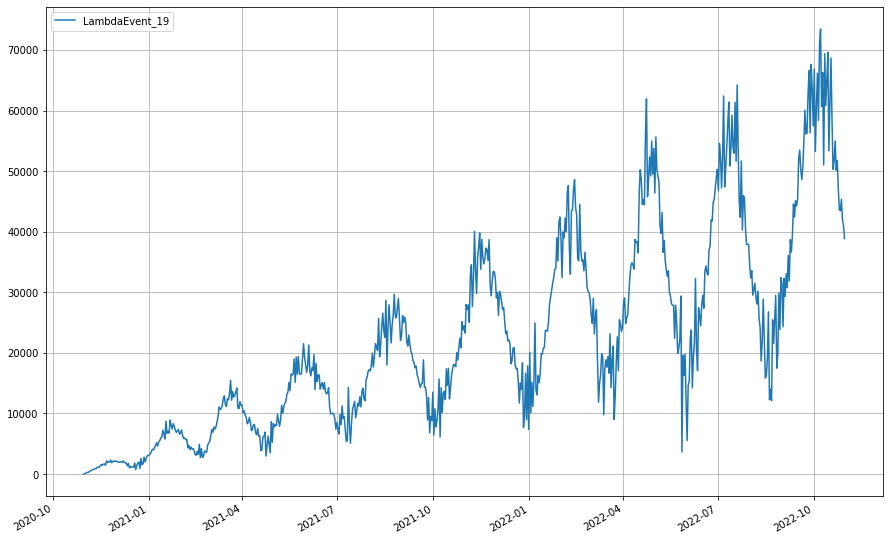

In [4]:
model = SimpleModels.cycle()
generate_and_plot(model, start_date=start_date, end_date=end_date, n=1)

### Classic Models: AR, MA, ARMA and ARIMA

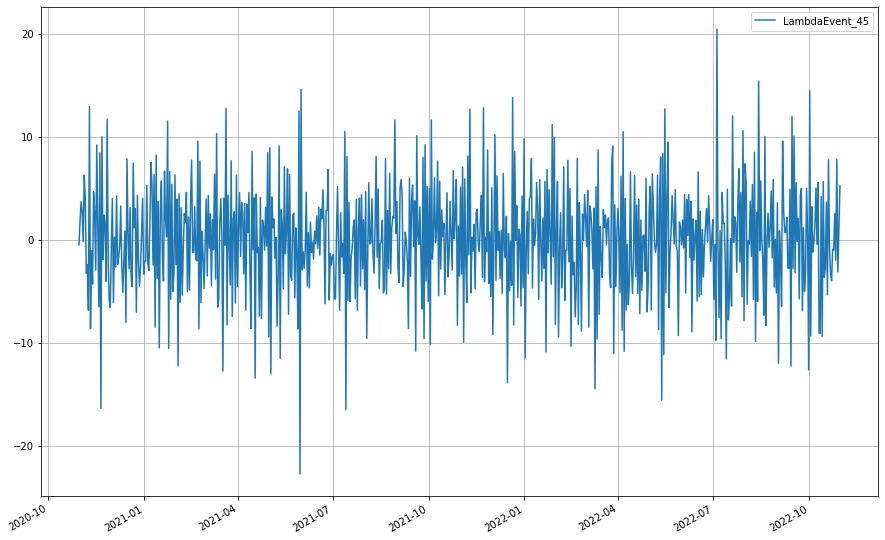

In [5]:
model = ClassicModels.ar(4)
generate_and_plot(model, start_date=start_date, end_date=end_date)

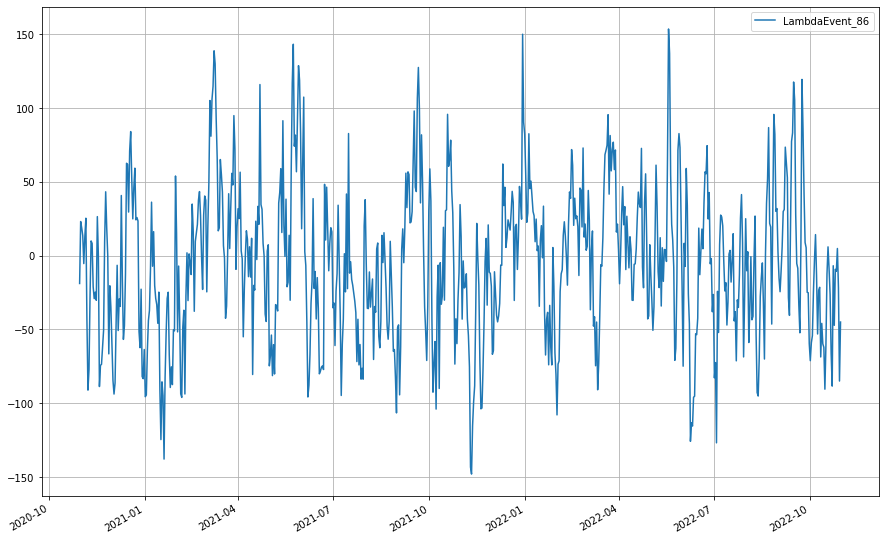

In [6]:
model = ClassicModels.ar(6, error_std=10, coefs=[0.5, 0, 0, 0.3, 0.1, 0.1])
generate_and_plot(model, start_date=start_date, end_date=end_date)

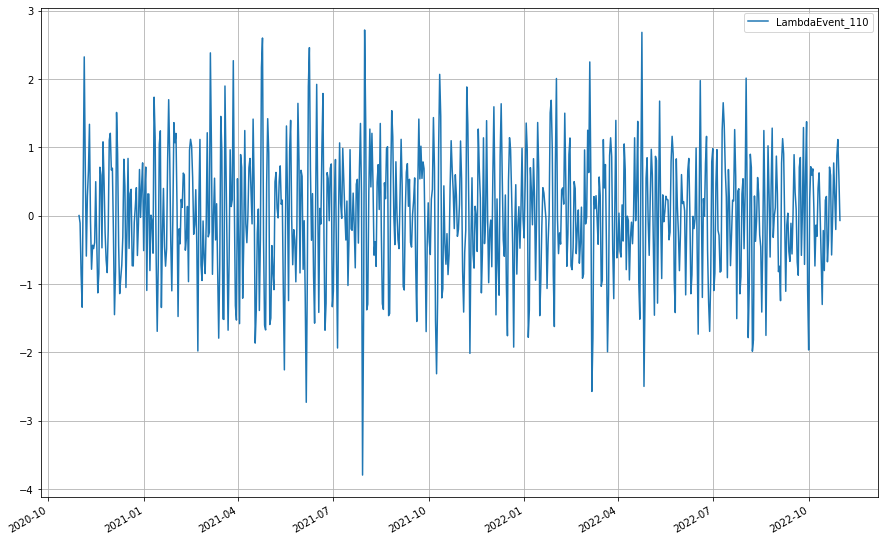

In [7]:
model = ClassicModels.ma(4)
generate_and_plot(model, start_date=start_date, end_date=end_date)

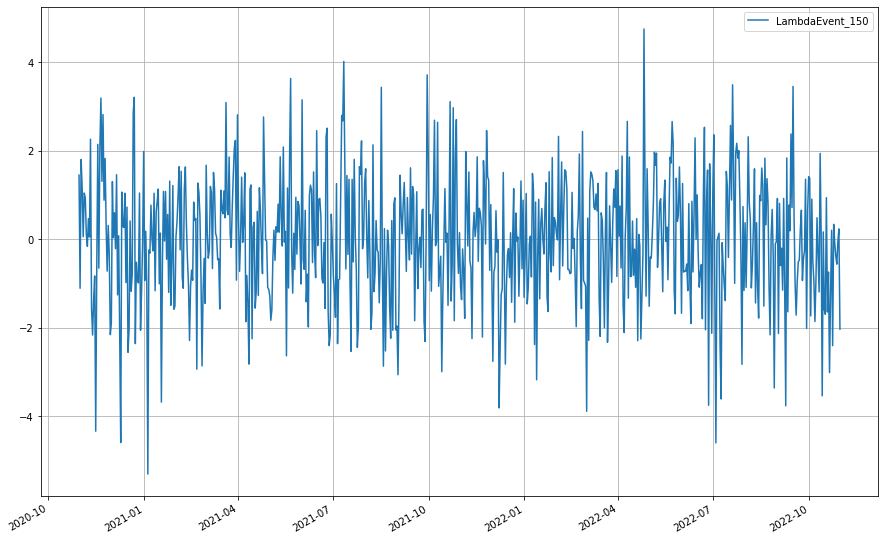

In [8]:
model = ClassicModels.arma(4, 2)
generate_and_plot(model, start_date=start_date, end_date=end_date)

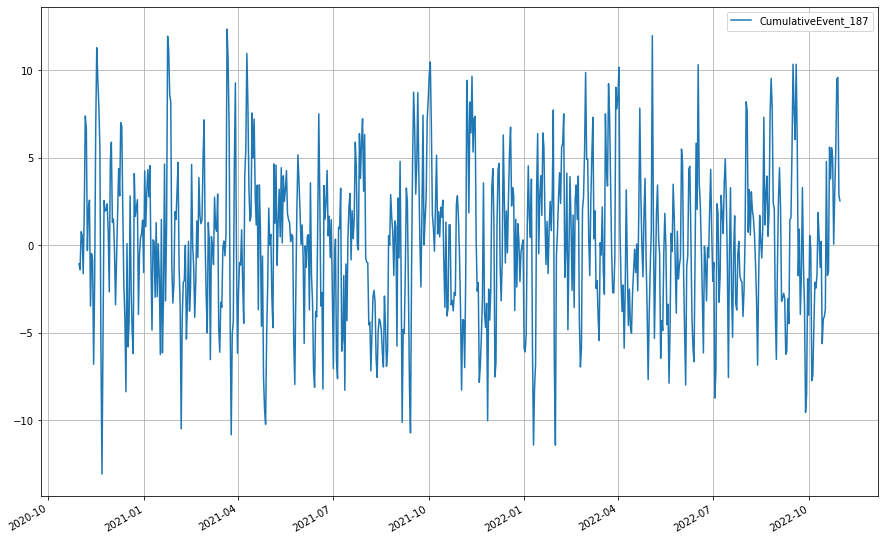

In [9]:
model = ClassicModels.arima(4, 2)
generate_and_plot(model, start_date=start_date, end_date=end_date)

### Banking

A simple model.

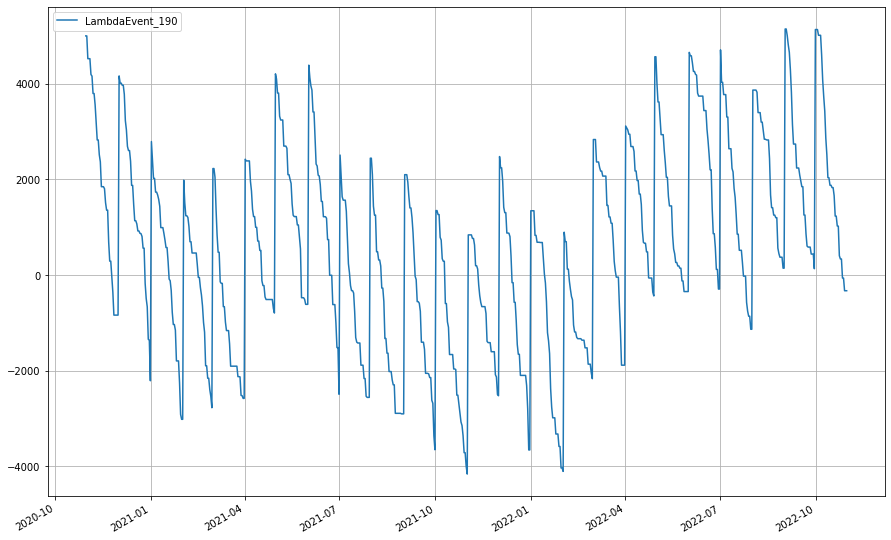

In [10]:
model = BankingModels.salary_earner_simple(expense_mean=100.0, expense_sd=300.0)
generate_and_plot(model, start_date=start_date, end_date=end_date)

A less simple model.

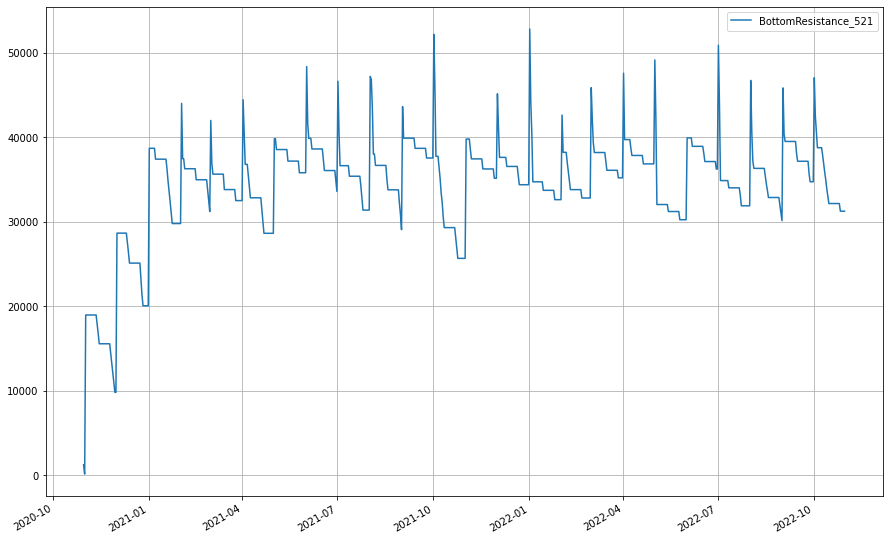

In [29]:
model = BankingModels.salary_earner(salary_value=20000)
generate_and_plot(model, start_date=start_date, end_date=end_date)

### Economics

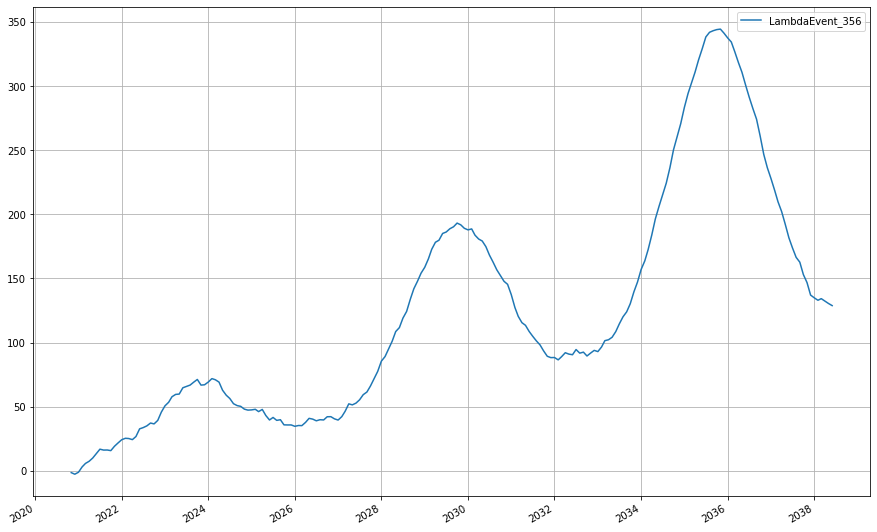

In [12]:
model = EconomicModels.kondratiev_business_cycle(base = 0.0, growth_mean = 1, growth_sd = 2,
                                                 wave_period= 72, wave_amplitude = 0.05)

generate_and_plot(model, start_date=start_date, end_date=pd.Timestamp(2038, 6, 30), freq='MS')

### Ecology 

The predator-prey relationship, as defined by so-called [Lotka–Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), is a classical ecological model. The equations are continuous, but here a discrete version is provided. Despite their simplicity, the behavior is actually quite surprising, owing to chaotic dynamics. For example, consider this first model.

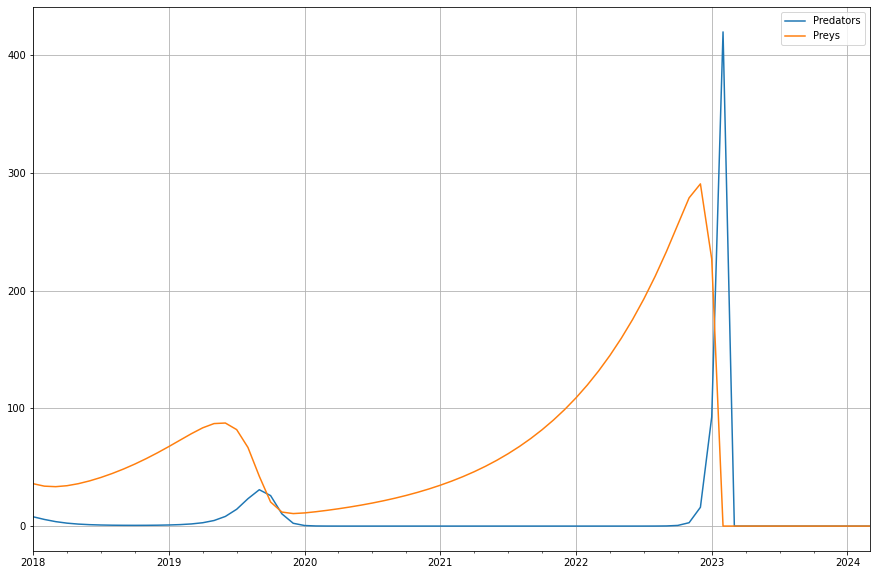

In [13]:
predators_model, preys_model = EcologyModels.predator_prey(n_predators=10, n_preys=40,
                                                                   alpha=1.1, beta=0.02, delta=0.02, gamma=0.008)


data = generate_and_plot([predators_model,preys_model], 
                         start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2024, 3, 30), 
                  freq='MS')

Now let us increase the `delta` parameter, which controls the predators' reproduction, in order to observe  different result. 

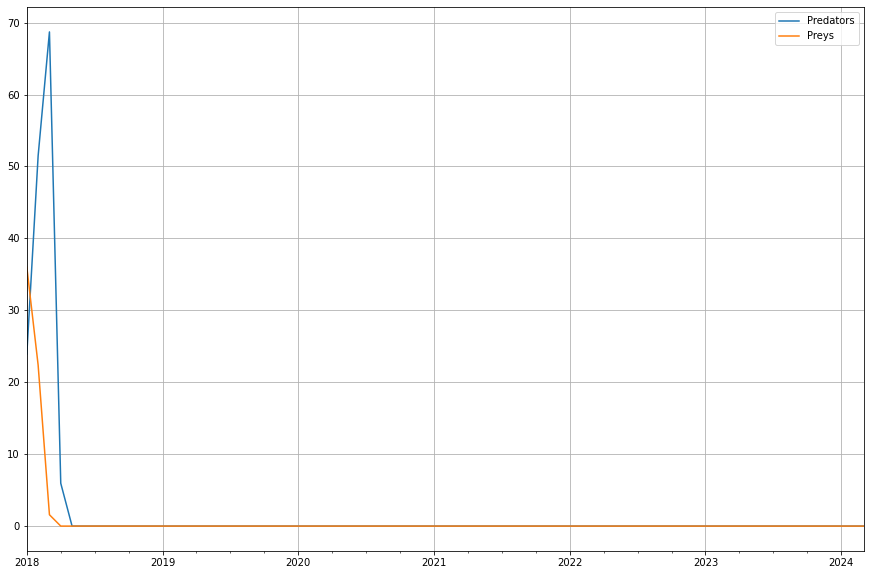

In [14]:
predators_model, preys_model = EcologyModels.predator_prey(n_predators=10, n_preys=40,
                                                                   alpha=1.1, beta=0.02, delta=0.06, gamma=0.008)


data = generate_and_plot([predators_model,preys_model], 
                         start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2024, 3, 30), 
                         freq='MS')

We see that the predators reproduce so efficiently that there is no time to allow the prey population to recover, causing both to be quickly extinct.

## Custom Models
The above predefined models are built using events provided by TimeBlender. Here, we will see some of these and how to combine them.

### Model Addition

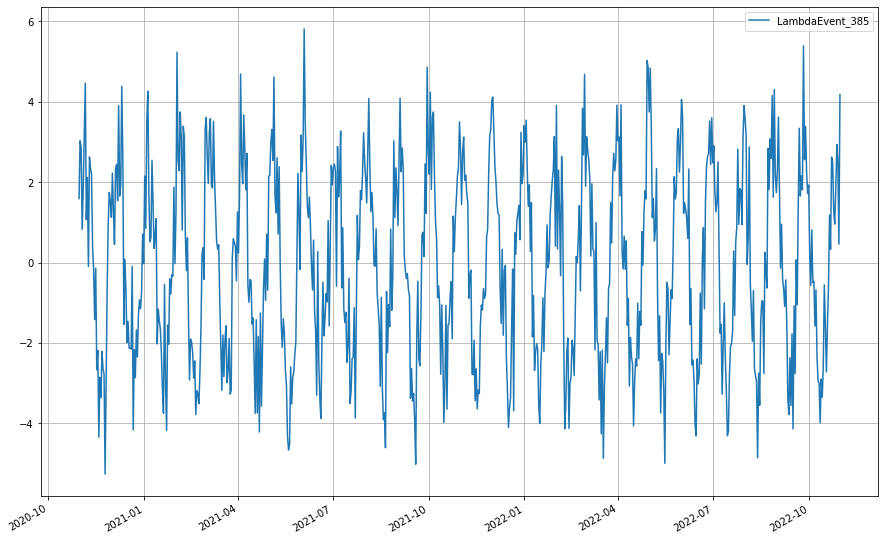

In [15]:
norm = NormalEvent(0, 1)
we = WaveEvent(30, 3)

compos = norm + we

generate_and_plot(compos, start_date=start_date, end_date=end_date)

### Random Walk

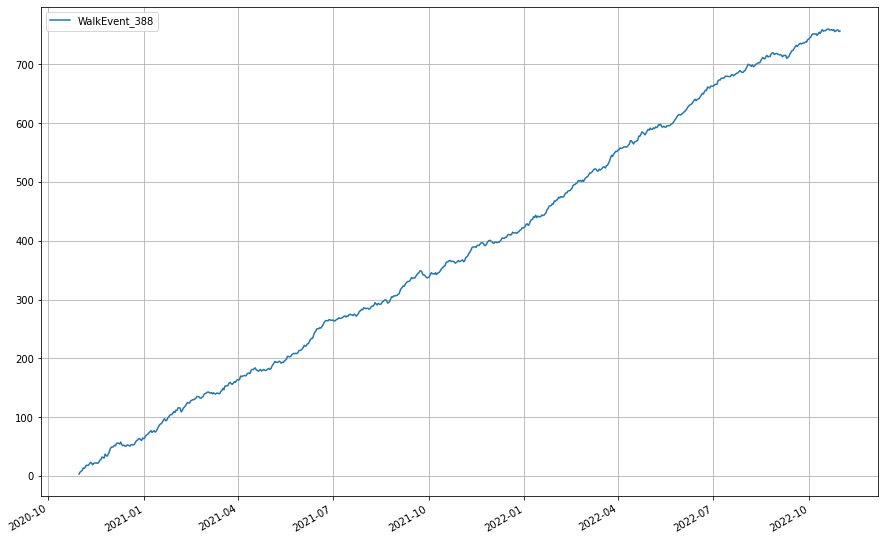

In [16]:
model = WalkEvent(NormalEvent(1, 2))
generate_and_plot(model, start_date=start_date, end_date=end_date)

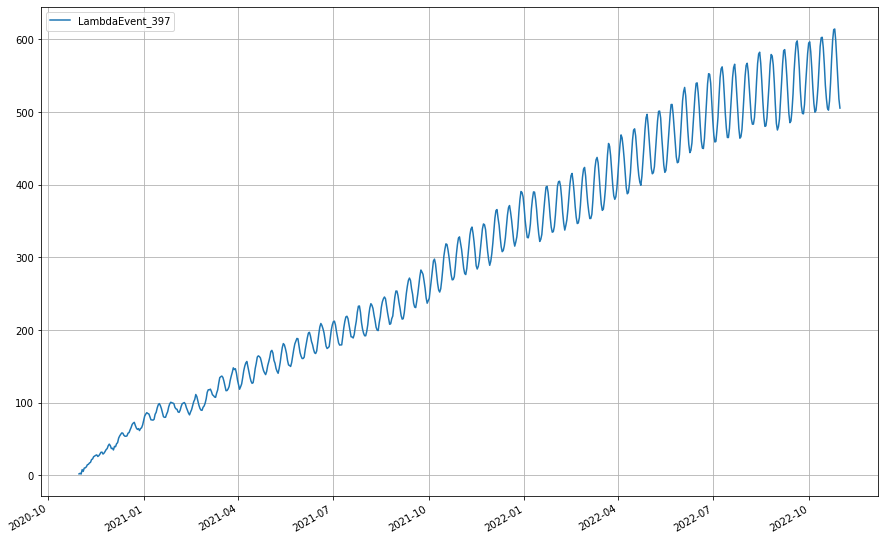

In [17]:
we = WaveEvent(12, 0.05)
model = WalkEvent(NormalEvent(1, 2)) * (ConstantEvent(1) + we)
generate_and_plot(model, start_date=start_date, end_date=end_date)

### More Complex Functional Compositions

Let's model a series that changes its behavior once, and such that each new behavior is itself a composition.

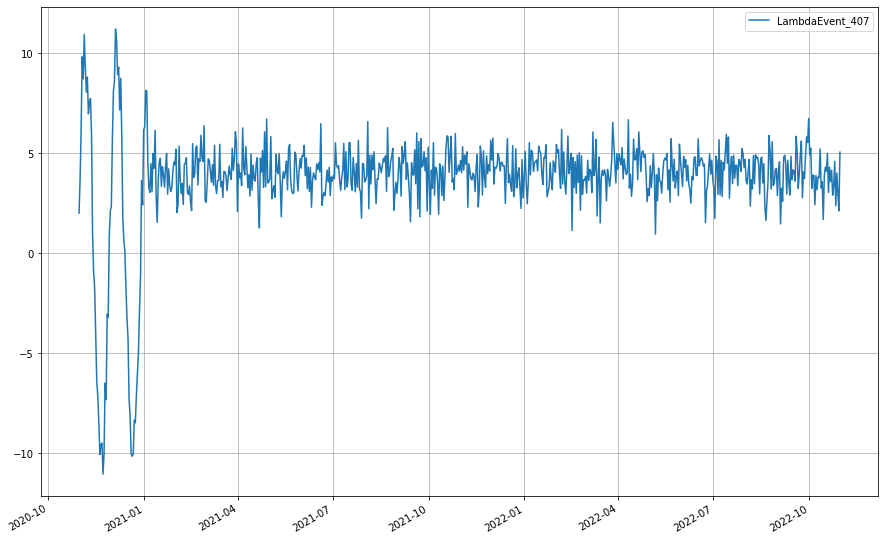

In [18]:
const = ConstantEvent(4)
norm = NormalEvent(0, 1)
we = WaveEvent(30, 10)
t_change = OnceEvent(UniformEvent(0, 90))

compos1 = we + norm
compos2 = const + norm

def aux(t, i, memory, sub_events):
    if i <= sub_events['t_change'].execute(t):
        return sub_events['compos1'].execute(t)
    else:
        return sub_events['compos2'].execute(t)

e = LambdaEvent(aux, sub_events={'t_change': t_change, 'compos1': compos1, 'compos2': compos2})

generate_and_plot(e, start_date=start_date, end_date=end_date)

We can also implement such regime change using the `Piecewise` event.

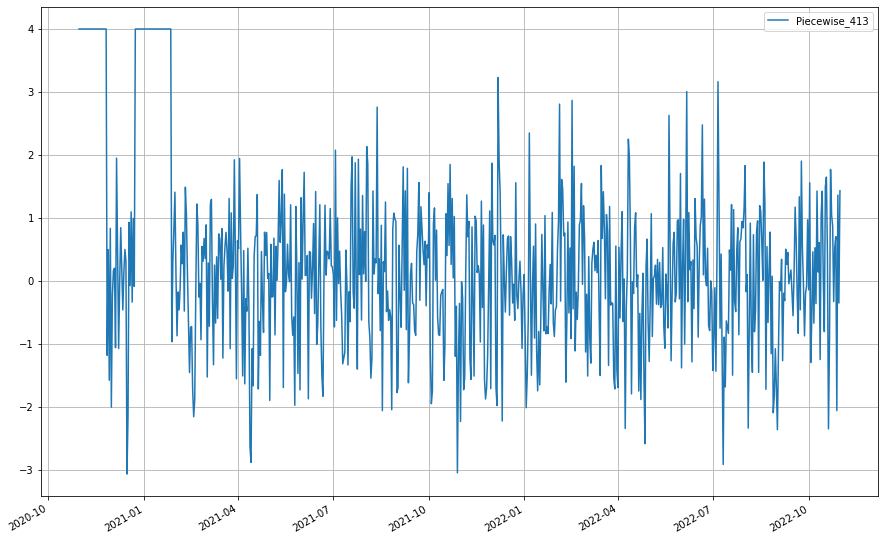

In [19]:
const = ConstantEvent(4)
norm = NormalEvent(0, 1)
#we = WaveEvent(30, 10)

model = Piecewise([const, norm, const, norm],  t_separators=[NormalEvent(30, 5), 
                                                             NormalEvent(60, 5), 
                                                             NormalEvent(90, 5)])

generate_and_plot(model, start_date=start_date, end_date=end_date)

We have seen so far arithimetic and piecewise combination. It is also possible, however, to implement more complex interactions. Here, we will define a top resistance with respect to a random walk. Note that, for this to work, the value after the resistance must be passed back to the underlying random walk event. This is achieved transparently.

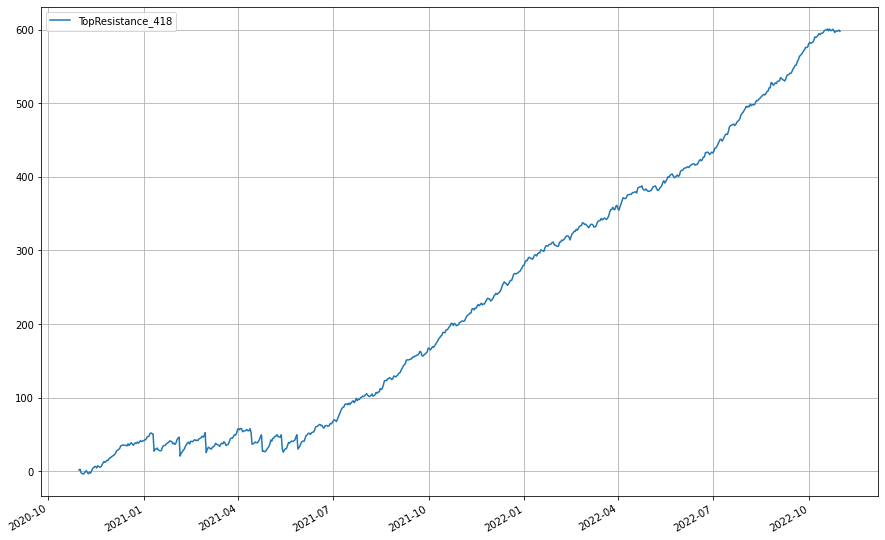

In [20]:
base = WalkEvent(NormalEvent(1, 2))
resistance_1 = NormalEvent(0.5, 0.1)
model = TopResistance(base, 
                      resistance_value_begin=50,
                      resistance_value_end=55,
                      resistance_probability=0.5, 
                      resistance_strength_event=resistance_1)

generate_and_plot(model, start_date=start_date, end_date=end_date)

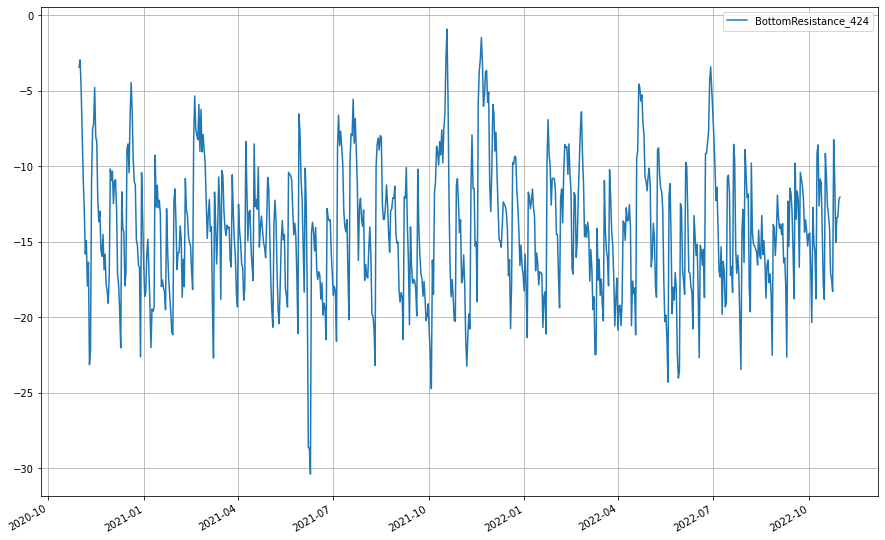

In [21]:
base = WalkEvent(NormalEvent(-1, 2))
resistance_1 = NormalEvent(0.5, 0.1)
model = BottomResistance(base, 
                      resistance_value_begin=-20,
                      resistance_value_end=-30,
                      resistance_probability=0.5, 
                      resistance_strength_event=resistance_1)

generate_and_plot(model, start_date=start_date, end_date=end_date)

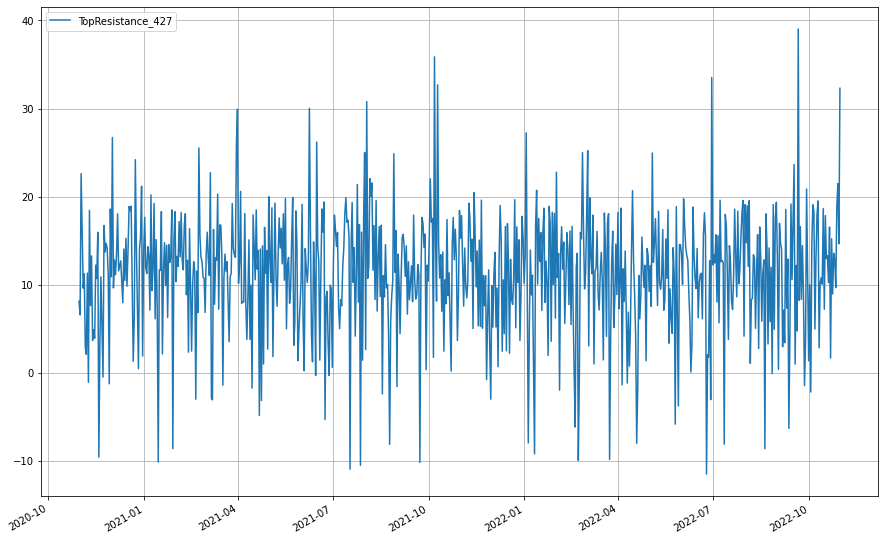

In [22]:
base = NormalEvent(15, 10)
model = TopResistance(base, 
                      resistance_value_begin=20,
                      resistance_value_end=50,
                      resistance_probability=0.9, 
                      resistance_strength_event=resistance_1)

generate_and_plot(model, start_date=start_date, end_date=end_date)

Multiple resistance levels can be defined.

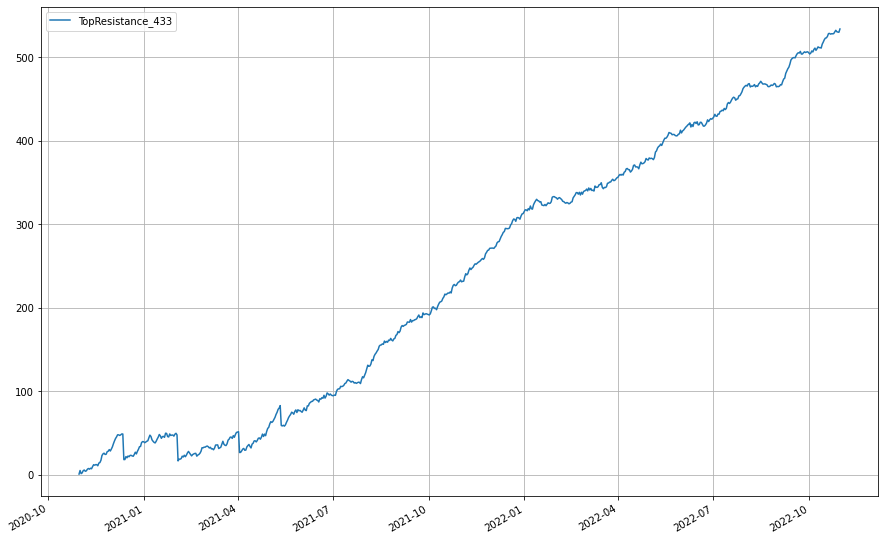

In [23]:
base = WalkEvent(NormalEvent(1, 2))
resistance_1 = NormalEvent(0.5, 0.1)

model = \
    TopResistance(
        TopResistance(base, 
                      resistance_value_begin=50,
                      resistance_value_end=55,
                      resistance_probability=0.5, 
                      resistance_strength_event=resistance_1),
        resistance_value_begin=80,
        resistance_value_end=85,
        resistance_probability=0.5, 
        resistance_strength_event=resistance_1)
    

generate_and_plot(model, start_date=start_date, end_date=end_date)

We can also use both bottom and top resistance, for instance to insert extra infornation in an AR model supposed to simulate a stock market.

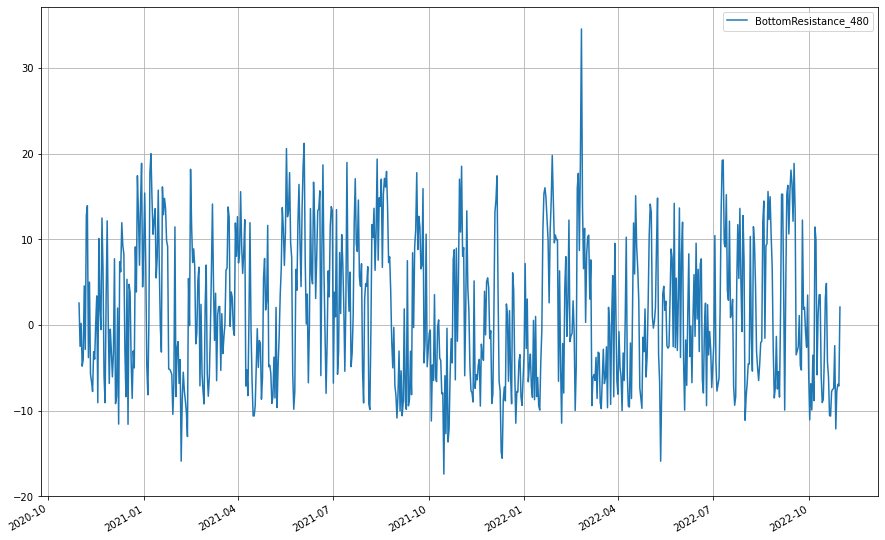

In [24]:
base = ClassicModels.ar(6, error_std=3, coefs=[0.5, 0, 0, 0.3, 0.1, 0.1])
resistance_1 = NormalEvent(0.5, 0.1)

model = \
    BottomResistance(
            TopResistance(base, 
                          resistance_value_begin=20,
                          resistance_value_end=80,
                          resistance_probability=0.999, 
                          resistance_strength_event=resistance_1),
        resistance_value_begin=-10,
        resistance_value_end=-80,
        resistance_probability=0.999, 
        resistance_strength_event=resistance_1)

generate_and_plot(model, start_date=start_date, end_date=end_date)

This shows how existing models can be enriched to achieve more detailed effects.

In fact, what if we want to model a business time series that do not change on weekends? Here's how to do it.

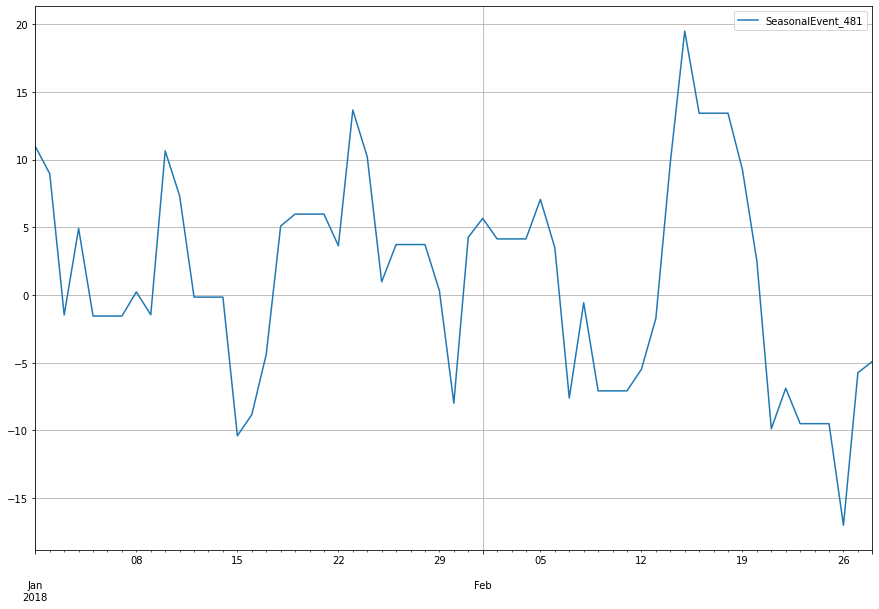

In [25]:
weekday_model = SeasonalEvent(model, default=None, is_weekday=True)

generate_and_plot(weekday_model, start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 2, 28))

What if we revert and the action only takes place on weekends?

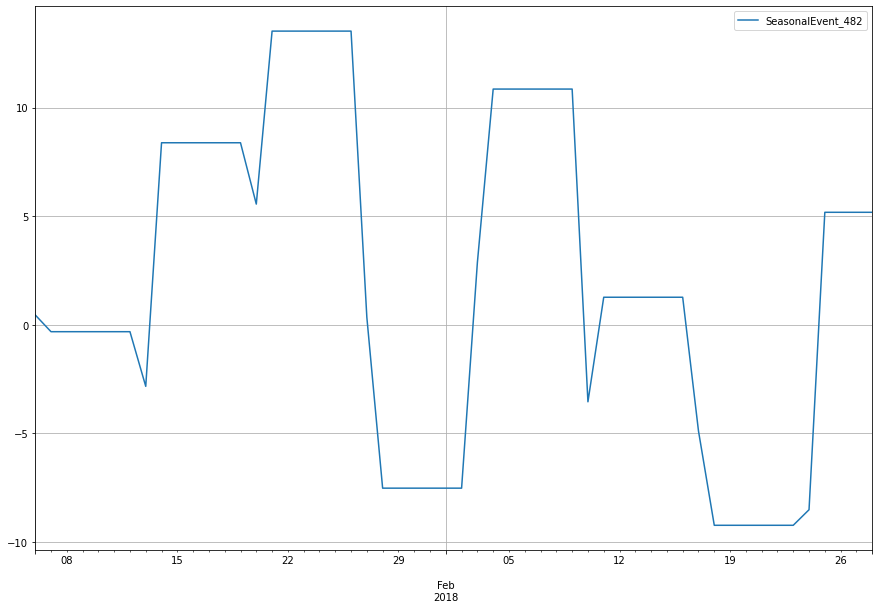

In [26]:
weekend_model = SeasonalEvent(model, default=None, is_weekend=True)

generate_and_plot(weekend_model, start_date=pd.Timestamp(2018, 1, 6), end_date=pd.Timestamp(2018, 2, 28))

## Exporting Data

The generated data is given as Pandas Series, so the usual Pandas mechanisms can be used both to customize and to export the generated data. 

In [27]:
data = generate(model,start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 6, 30), 
                      n=1, freq='D')

In [28]:
data.to_csv('example_output.csv')
data

,BottomResistance_480
2018-01-01,7.481069
2018-01-02,-0.117861
2018-01-03,1.141133
2018-01-04,11.437124
2018-01-05,7.830849
...,...
2018-06-26,-3.606117
2018-06-27,-6.124696
2018-06-28,5.291252
2018-06-29,-9.990182
